In [1]:
import pandas as pd
df = pd.read_csv('las_vegas_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:58:10.045000,RUS,63,0 days 00:01:43.267000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:33.383000,...,False,Mercedes,0 days 00:56:26.961000,2024-11-24 06:03:40.011,1,1.0,False,NaN,False,False
1,0 days 00:59:49.122000,RUS,63,0 days 00:01:39.077000,2.0,1.0,NaN,NaN,0 days 00:00:28.738000,0 days 00:00:33.235000,...,False,Mercedes,0 days 00:58:10.045000,2024-11-24 06:05:23.095,1,1.0,False,NaN,False,True
2,0 days 01:01:27.986000,RUS,63,0 days 00:01:38.864000,3.0,1.0,NaN,NaN,0 days 00:00:28.368000,0 days 00:00:33.152000,...,False,Mercedes,0 days 00:59:49.122000,2024-11-24 06:07:02.172,1,1.0,False,NaN,False,True
3,0 days 01:03:06.734000,RUS,63,0 days 00:01:38.748000,4.0,1.0,NaN,NaN,0 days 00:00:28.229000,0 days 00:00:32.970000,...,False,Mercedes,0 days 01:01:27.986000,2024-11-24 06:08:41.036,1,1.0,False,NaN,False,True
4,0 days 01:04:44.870000,RUS,63,0 days 00:01:38.136000,5.0,1.0,NaN,NaN,0 days 00:00:28.341000,0 days 00:00:32.594000,...,False,Mercedes,0 days 01:03:06.734000,2024-11-24 06:10:19.784,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,0 days 01:15:15.346000,GAS,10,0 days 00:01:56.714000,11.0,2.0,0 days 01:13:38.575000,NaN,0 days 00:00:46.394000,0 days 00:00:33.574000,...,True,Alpine,0 days 01:13:18.632000,2024-11-24 06:20:31.682,1,16.0,False,NaN,False,False
934,0 days 01:16:53.967000,GAS,10,0 days 00:01:38.621000,12.0,2.0,NaN,NaN,0 days 00:00:28.946000,0 days 00:00:33.114000,...,True,Alpine,0 days 01:15:15.346000,2024-11-24 06:22:28.396,1,13.0,False,NaN,False,True
935,0 days 01:18:32.281000,GAS,10,0 days 00:01:38.314000,13.0,2.0,NaN,NaN,0 days 00:00:28.549000,0 days 00:00:33.057000,...,True,Alpine,0 days 01:16:53.967000,2024-11-24 06:24:07.017,1,13.0,False,NaN,False,True
936,0 days 01:20:12.529000,GAS,10,0 days 00:01:40.248000,14.0,2.0,NaN,NaN,0 days 00:00:28.654000,0 days 00:00:34.107000,...,True,Alpine,0 days 01:18:32.281000,2024-11-24 06:25:45.331,1,13.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 50  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              1              10.0          12.500000   
1    ALO              2               5.0          16.666667   
2    BOT              2              18.0          16.333333   
3    COL              2              17.0          16.666667   
4    GAS              1              11.0           7.500000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0              0.00          0.360000         0.640000  
1              0.08          0.000000         0.920000  
2              0.00          0.367347         0.632653  
3              0.00          0.200000         0.800000  
4              0.00          0.666667         0.333333  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,9.0,0 days 01:11:43.570000,NaN,MEDIUM,9.0,1.0
1,ALB,10.0,NaN,0 days 01:12:05.662000,HARD,1.0,2.0
2,ALB,25.0,0 days 01:38:36.164000,NaN,HARD,16.0,2.0
3,ALO,4.0,0 days 01:03:23.149000,NaN,SOFT,4.0,1.0
4,ALO,5.0,NaN,0 days 01:03:44.470000,HARD,2.0,2.0
...,...,...,...,...,...,...,...
75,VER,28.0,NaN,0 days 01:41:40.199000,HARD,1.0,3.0
76,ZHO,11.0,0 days 01:15:01.897000,NaN,MEDIUM,12.0,1.0
77,ZHO,12.0,NaN,0 days 01:15:24.875000,HARD,2.0,2.0
78,ZHO,34.0,0 days 01:53:32.498000,NaN,HARD,24.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,10.0,12.500000,0.000000,0.360000,0.640000
1,ALO,2,5.0,16.666667,0.080000,0.000000,0.920000
2,BOT,2,18.0,16.333333,0.000000,0.367347,0.632653
3,COL,2,17.0,16.666667,0.000000,0.200000,0.800000
4,GAS,1,11.0,7.500000,0.000000,0.666667,0.333333
5,HAM,2,14.0,16.666667,0.000000,0.260000,0.740000
6,HUL,2,15.0,16.666667,0.000000,0.280000,0.720000
7,LAW,2,12.0,16.666667,0.000000,0.220000,0.780000
8,LEC,2,10.0,16.666667,0.000000,0.180000,0.820000
9,MAG,1,18.0,25.000000,0.000000,0.340000,0.660000


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,826


In [9]:
df['Driver'].value_counts()


,count
Driver,
MAG,47
PER,45
HUL,45
TSU,45
ALO,45
STR,45
COL,45
ZHO,45
VER,44


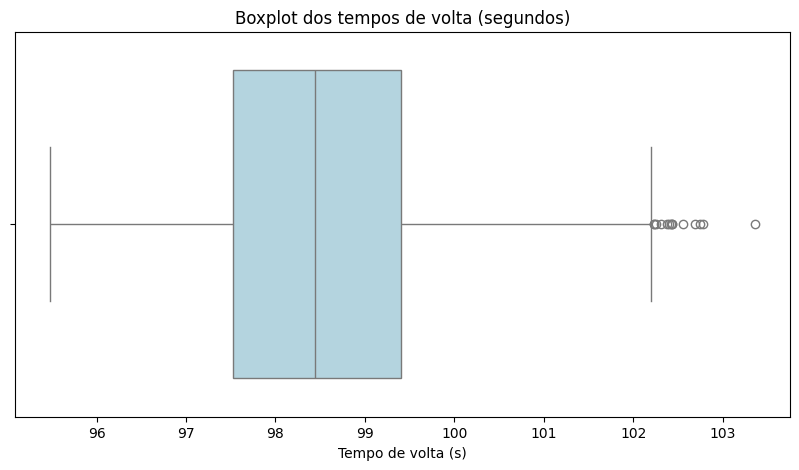

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


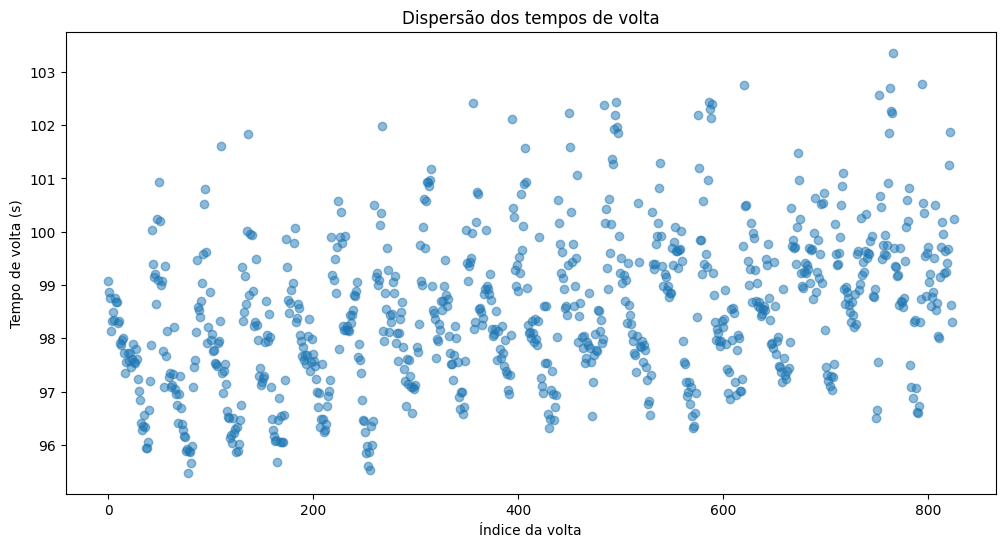

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


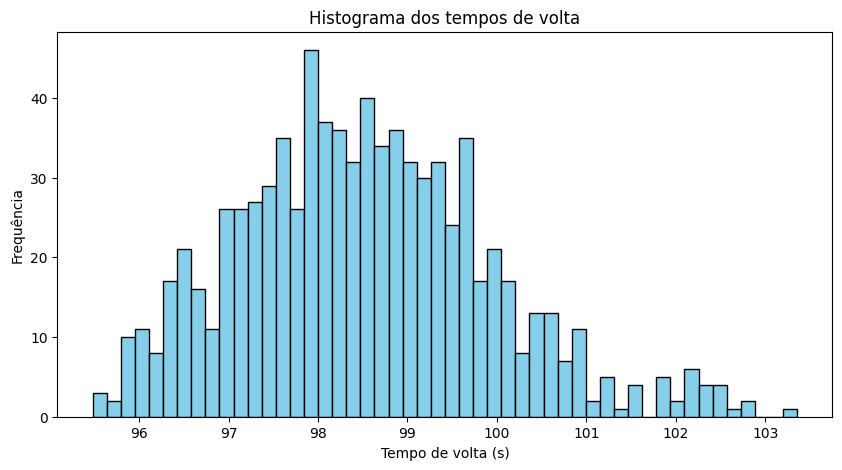

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


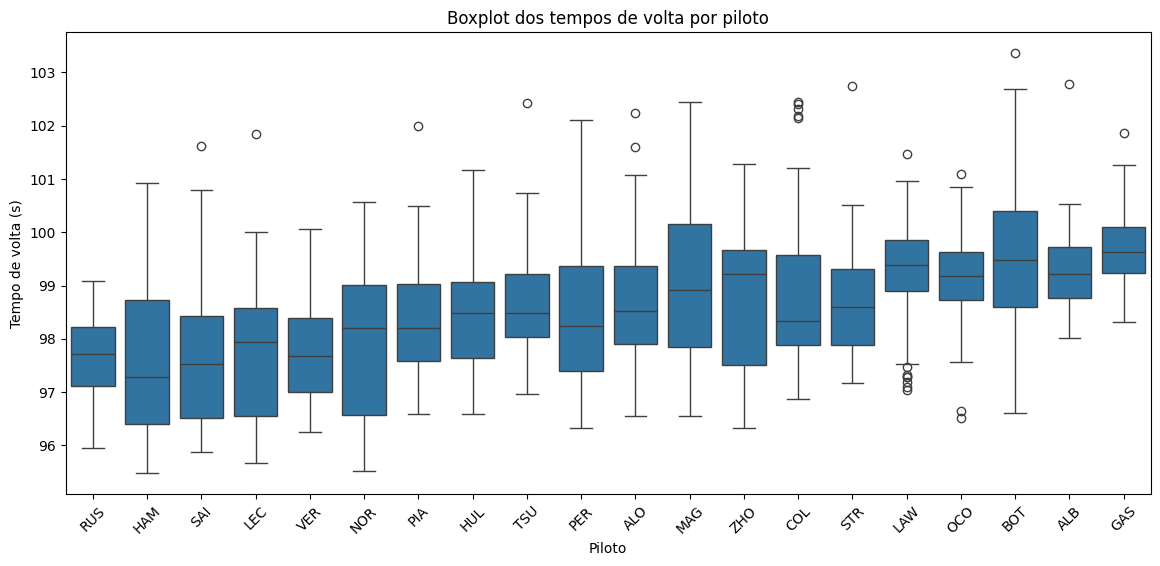

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
HAM   0 days 00:01:35.480000
NOR   0 days 00:01:35.527000
LEC   0 days 00:01:35.674000
SAI   0 days 00:01:35.875000
RUS   0 days 00:01:35.946000
VER   0 days 00:01:36.248000
ZHO   0 days 00:01:36.324000
PER   0 days 00:01:36.326000
OCO   0 days 00:01:36.511000
ALO   0 days 00:01:36.553000
MAG   0 days 00:01:36.557000
HUL   0 days 00:01:36.585000
PIA   0 days 00:01:36.598000
BOT   0 days 00:01:36.601000
COL   0 days 00:01:36.867000
TSU   0 days 00:01:36.957000
LAW   0 days 00:01:37.033000
STR   0 days 00:01:37.179000
ALB   0 days 00:01:38.008000
GAS   0 days 00:01:38.314000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Las Vegas'
race_date = '2024-11-24'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,21,99.433952,1.063927,98.008,102.776,99.2110,4.768,2024,Las Vegas,2024-11-24
1,ALO,45,98.723178,1.171094,96.553,102.232,98.5130,5.679,2024,Las Vegas,2024-11-24
2,BOT,42,99.480881,1.702456,96.601,103.358,99.4750,6.757,2024,Las Vegas,2024-11-24
3,COL,45,98.858556,1.608208,96.867,102.436,98.3330,5.569,2024,Las Vegas,2024-11-24
4,GAS,11,99.767636,1.049840,98.314,101.862,99.6350,3.548,2024,Las Vegas,2024-11-24
5,HAM,44,97.578159,1.412626,95.480,100.926,97.2840,5.446,2024,Las Vegas,2024-11-24
6,HUL,45,98.589889,1.285795,96.585,101.171,98.4810,4.586,2024,Las Vegas,2024-11-24
7,LAW,43,99.223116,1.135895,97.033,101.469,99.3850,4.436,2024,Las Vegas,2024-11-24
8,LEC,43,97.771605,1.361438,95.674,101.841,97.9330,6.167,2024,Las Vegas,2024-11-24
9,MAG,47,99.108617,1.642163,96.557,102.439,98.9230,5.882,2024,Las Vegas,2024-11-24


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,21,99.433952,1.063927,98.008,102.776,99.2110,4.768,2024,Las Vegas,2024-11-24,25.0,False
1,ALO,45,98.723178,1.171094,96.553,102.232,98.5130,5.679,2024,Las Vegas,2024-11-24,50.0,True
2,BOT,42,99.480881,1.702456,96.601,103.358,99.4750,6.757,2024,Las Vegas,2024-11-24,49.0,True
3,COL,45,98.858556,1.608208,96.867,102.436,98.3330,5.569,2024,Las Vegas,2024-11-24,50.0,True
4,GAS,11,99.767636,1.049840,98.314,101.862,99.6350,3.548,2024,Las Vegas,2024-11-24,15.0,False
5,HAM,44,97.578159,1.412626,95.480,100.926,97.2840,5.446,2024,Las Vegas,2024-11-24,50.0,True
6,HUL,45,98.589889,1.285795,96.585,101.171,98.4810,4.586,2024,Las Vegas,2024-11-24,50.0,True
7,LAW,43,99.223116,1.135895,97.033,101.469,99.3850,4.436,2024,Las Vegas,2024-11-24,50.0,True
8,LEC,43,97.771605,1.361438,95.674,101.841,97.9330,6.167,2024,Las Vegas,2024-11-24,50.0,True
9,MAG,47,99.108617,1.642163,96.557,102.439,98.9230,5.882,2024,Las Vegas,2024-11-24,50.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,1,10.0,12.500000,0.000000,0.360000,0.640000
1,ALO,2,5.0,16.666667,0.080000,0.000000,0.920000
2,BOT,2,18.0,16.333333,0.000000,0.367347,0.632653
3,COL,2,17.0,16.666667,0.000000,0.200000,0.800000
4,GAS,1,11.0,7.500000,0.000000,0.666667,0.333333
5,HAM,2,14.0,16.666667,0.000000,0.260000,0.740000
6,HUL,2,15.0,16.666667,0.000000,0.280000,0.720000
7,LAW,2,12.0,16.666667,0.000000,0.220000,0.780000
8,LEC,2,10.0,16.666667,0.000000,0.180000,0.820000
9,MAG,1,18.0,25.000000,0.000000,0.340000,0.660000


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,21,99.433952,1.063927,98.008,102.776,99.2110,4.768,2024,Las Vegas,2024-11-24,25.0,False,1,10.0,12.500000,0.000000,0.360000,0.640000
1,ALO,45,98.723178,1.171094,96.553,102.232,98.5130,5.679,2024,Las Vegas,2024-11-24,50.0,True,2,5.0,16.666667,0.080000,0.000000,0.920000
2,BOT,42,99.480881,1.702456,96.601,103.358,99.4750,6.757,2024,Las Vegas,2024-11-24,49.0,True,2,18.0,16.333333,0.000000,0.367347,0.632653
3,COL,45,98.858556,1.608208,96.867,102.436,98.3330,5.569,2024,Las Vegas,2024-11-24,50.0,True,2,17.0,16.666667,0.000000,0.200000,0.800000
4,GAS,11,99.767636,1.049840,98.314,101.862,99.6350,3.548,2024,Las Vegas,2024-11-24,15.0,False,1,11.0,7.500000,0.000000,0.666667,0.333333
5,HAM,44,97.578159,1.412626,95.480,100.926,97.2840,5.446,2024,Las Vegas,2024-11-24,50.0,True,2,14.0,16.666667,0.000000,0.260000,0.740000
6,HUL,45,98.589889,1.285795,96.585,101.171,98.4810,4.586,2024,Las Vegas,2024-11-24,50.0,True,2,15.0,16.666667,0.000000,0.280000,0.720000
7,LAW,43,99.223116,1.135895,97.033,101.469,99.3850,4.436,2024,Las Vegas,2024-11-24,50.0,True,2,12.0,16.666667,0.000000,0.220000,0.780000
8,LEC,43,97.771605,1.361438,95.674,101.841,97.9330,6.167,2024,Las Vegas,2024-11-24,50.0,True,2,10.0,16.666667,0.000000,0.180000,0.820000
9,MAG,47,99.108617,1.642163,96.557,102.439,98.9230,5.882,2024,Las Vegas,2024-11-24,50.0,True,1,18.0,25.000000,0.000000,0.340000,0.660000


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoLasVegas.csv', index=False)
